In [1]:
import sys
from os import getenv
sys.path.append(getenv("DEVENV_ROOT"))

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import pendulum
import greenflow.analysis as an
from entrypoint import load_gin
from greenflow.utils import convert_to_mib
import qgridnext as qgrid

cutoff_begin = "2025-01-06T06:15:35.626996+01:00"
cutoff_end = pendulum.now().to_iso8601_string()
# cutoff_end = "2025-01-09T14:16:52.033680+01:00"
print(cutoff_end)

load_gin(exp_name="ingest-kafka", test=False)

2025-01-20T01:55:10.528071+01:00


[WARNING]: failed to patch stdout/stderr for fork-safety: 'OutStream' object
has no attribute 'buffer'
[WARNING]: failed to reconfigure stdout/stderr with the replace error handler:
'OutStream' object has no attribute 'reconfigure'


In [8]:
def plot_throughput_vs_replicas(enriched_data: pd.DataFrame):
    redpanda_df = enriched_data[enriched_data["exp_name"] == "ingest-redpanda"]
    kafka_df = enriched_data[enriched_data["exp_name"] == "ingest-kafka"]
    sns.boxplot(data=enriched_data, x='broker_replicas', y='throughput_MBps')
    plt.title('Throughput vs Brokers (Kafka - HDD)')
    plt.xlabel('Brokers')
    plt.ylabel('Throughput (MBps)')
    plt.grid(True)
    plt.show()


In [14]:
grappe_kafka = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin, cutoff_end=cutoff_end, exp_name="ingest-kafka", cluster="grappe", type="scalingBehaviour", partitions=120,
)
taurus_kafka = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin, cutoff_end=cutoff_end, exp_name="ingest-kafka", cluster="taurus", type="scalingBehaviour", partitions=120,
)

# qgrid.show_grid(taurus_kafka)

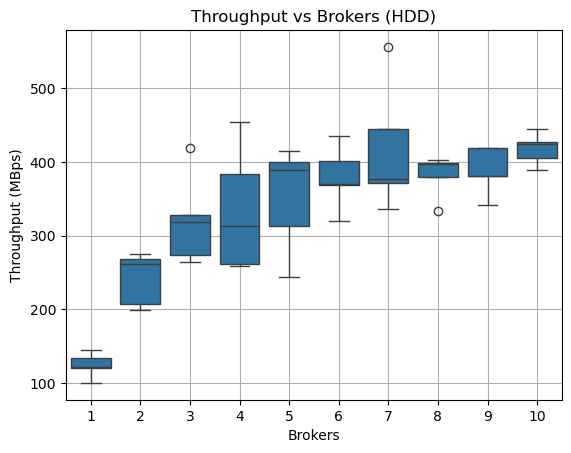

In [ ]:
plot_throughput_vs_replicas(taurus_kafka)

In [ ]:
grappe_redpanda = an.full_analytical_pipeline(
    cutoff_begin=cutoff_begin, cutoff_end=cutoff_end, exp_name="ingest-redpanda", cluster="grappe", type="scalingBehaviour", partitions=120,
)

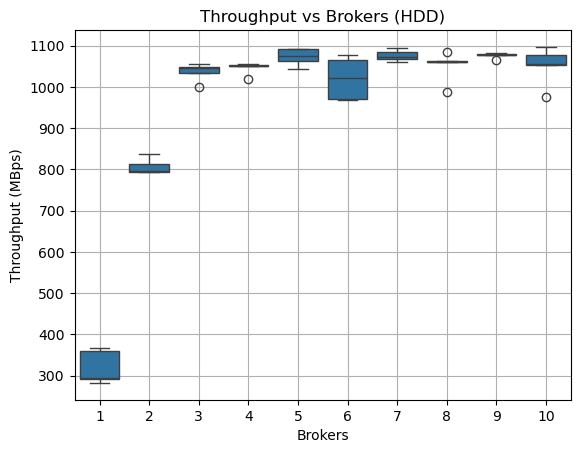

In [15]:

plot_throughput_vs_replicas(grappe_kafka)